## Skin Cancer Detection Using CNN

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [ ]:
# Importing all the necessary libraries for model building and training

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pathlib
import PIL
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Using the data by mounting the google drive since we need to run the model in Google Colab

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for training images

data_dir_train = pathlib.Path(r'/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_train

PosixPath('/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [4]:
# Defining the path for test images

data_dir_test = pathlib.Path(r'/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
data_dir_test

PosixPath('/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
# Let's find out the total number of images in both training and test data sets

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('No of images in training dataset: {}'.format(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('No of images in test dataset: {}'.format(image_count_test))

No of images in training dataset: 2239
No of images in test dataset: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
# Setting some parameters below for loading

batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width, 3)

Using 80% of the images for training, and 20% for validation.

In [7]:
# Creating training data set out of Train images - Using 80% of the images for training
# Also resizing the image to 180x180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train,
                seed=123,
                validation_split=0.2,
                subset = 'training',
                image_size=(img_height, img_width),
                batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Creating validation data set out of Train images - Using 20% of the images for validation
# Also resizing the image to 180x180

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train,
                seed=123,
                validation_split=0.2,
                subset='validation',
                image_size=(img_height, img_width),
                batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

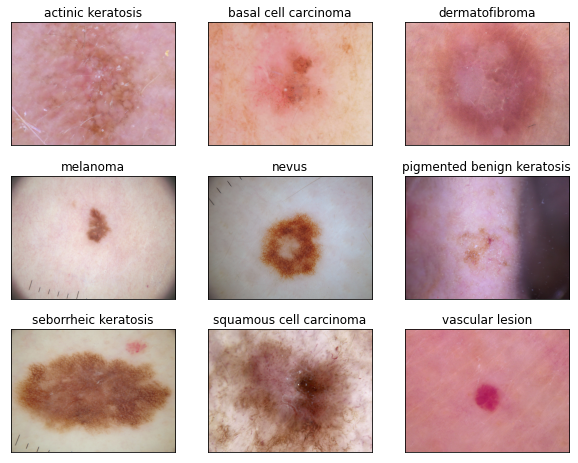

In [10]:
# Visualising one random instance of all the 9 clasess from training dataset

fig = plt.figure(figsize=(10,8))

for i in range(len(class_names)):
    ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
    img_cls = list(data_dir_train.glob(class_names[i]+'/*'))
    img = PIL.Image.open(img_cls[np.random.randint(len(img_cls))])
    ax.set_title(class_names[i])
    plt.imshow(img)

plt.show()

In [11]:
# Let's check the total number of images present in each class of cancer data set (Training images)

total_img = []

for i in range(len(class_names)):
    img_cls = list(data_dir_train.glob(class_names[i]+'/*'))
    #dic.update({class_names[i]:len(img_cls)})
    total_img.append(len(img_cls))

class_df = pd.DataFrame({'Class':class_names, 'Total Images':total_img})
class_df

,Class,Total Images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


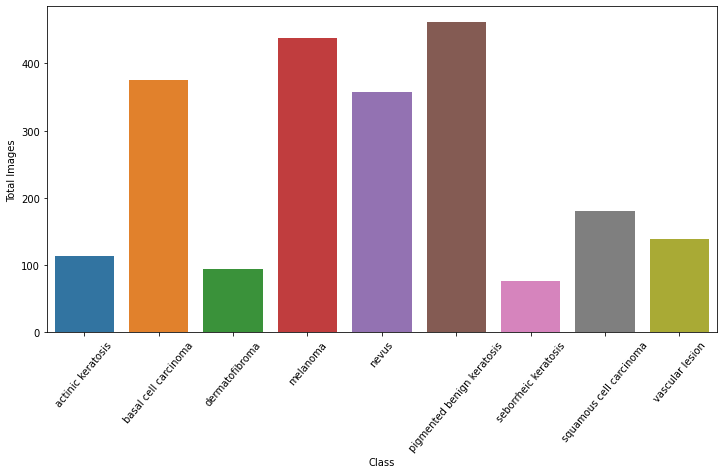

In [12]:
# Also check the distribution of cancer data classes present in training images using barplot

plt.figure(figsize=(12,6))
sns.barplot(data=class_df, x='Class', y='Total Images')
plt.xticks(rotation=50)
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Configure the dataset for performance

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Use buffered prefetching to yield data from disk without having I/O become blocking

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - M1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
# This simple model consists of three convolution blocks with a max pooling layer in each of them
# There's a fully connected layer with 128 units on top of it that is activated by a relu activation function
# Model has not been tuned for high accuracy or overfit
# Also the image pixels have been normalized between [0,1] using Rescaling

model = Sequential([
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        Conv2D(16, 3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(class_names), activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
# Compiling the model using adam optimizer and sparse categorical cross entropy

model.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [16]:
# View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [17]:
# Training the model for 20 epochs

epochs = 20
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 17s 72ms/step - loss: 1.9978 - accuracy: 0.2740 - val_loss: 1.8070 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6257 - accuracy: 0.4141 - val_loss: 1.5050 - val_accuracy: 0.5034
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4140 - accuracy: 0.5123 - val_loss: 1.4914 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3056 - accuracy: 0.5402 - val_loss: 1.3484 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.2321 - accuracy: 0.5698 - val_loss: 1.3241 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1629 - accuracy: 0.5882 - val_loss: 1.3548 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0829 - accuracy: 0.6144 - val_loss: 1.4656 - val_accuracy: 0.5145
Epoch 8/20
56/56 [=====

### Visualizing training results

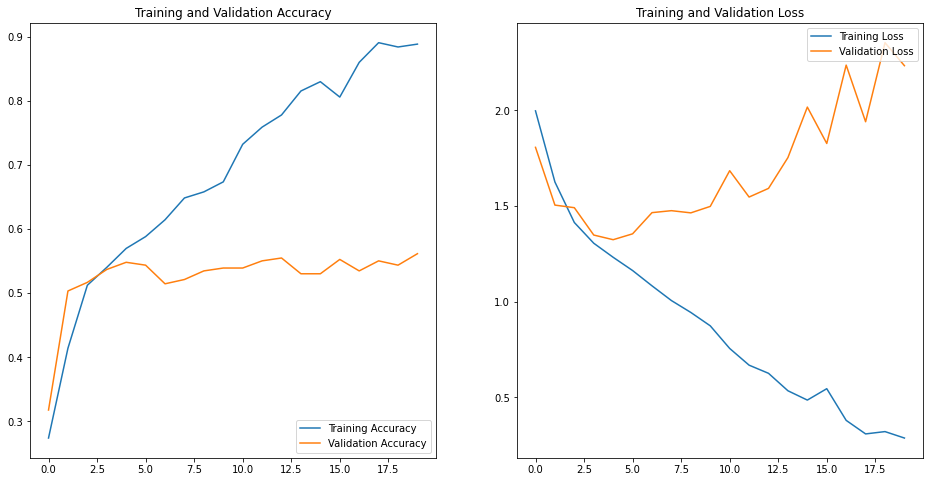

In [18]:
# Let's see the training and validation accuracy and loss after model is trained for 20 epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**: 
1. As we can see from the above plots, there is a clear sign of model overfitting, where the training and validation accuracy differ by a large margin. Training accuracy is close to 89% whereas the validation accuracy is around 56%.
2. Also the validation loss increases as we run the model for more epochs and at the same time, training loss decreases which indicates that model has clearly overfitted

Applying the other techniques to overcome the model overfitting problem

### Data Augmentation Strategy

In [19]:
# We have analysed the model fit history for presence of overfit
# Choosing below appropriate data augumentation technique

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

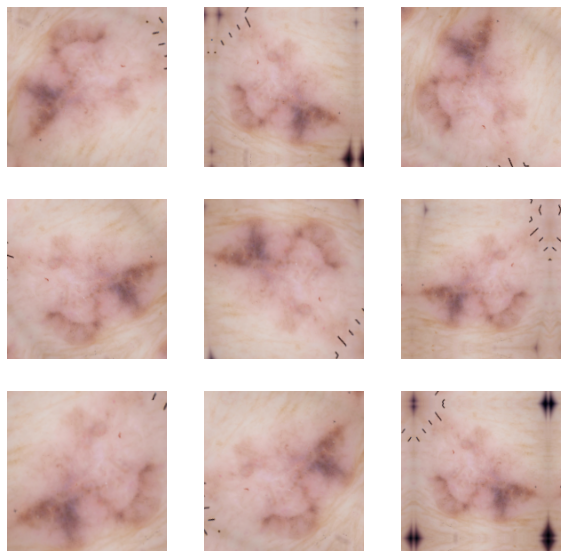

In [20]:
# Let's visualize how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### Create the model - M2
#### Create another model with data augmentation strategy applied to the training images. Also to prevent overfitting, as seen from simple model M1, dropout layer is used.

In [21]:
# Building the model with data augmentation and dropout technique

model2 = Sequential([
        Rescaling(1./255, input_shape=image_size),
        data_augmentation,
        Conv2D(16, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(class_names), activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [22]:
# Compiling the model using adam optimizer and sparse categorical cross entropy

model2.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [23]:
# View the summary of all layers

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Train the model

In [24]:
# Training the model for 20 epochs

epochs = 20
history2 = model2.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 2s 26ms/step - loss: 1.9291 - accuracy: 0.3131 - val_loss: 1.6575 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6342 - accuracy: 0.4135 - val_loss: 1.5246 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5517 - accuracy: 0.4414 - val_loss: 1.5035 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4746 - accuracy: 0.4833 - val_loss: 1.5027 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4269 - accuracy: 0.5078 - val_loss: 1.5277 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4372 - accuracy: 0.4805 - val_loss: 1.4452 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3622 - accuracy: 0.5106 - val_loss: 1.5501 - val_accuracy: 0.4743
Epoch 8/20
56/56 [======

### Visualizing the results

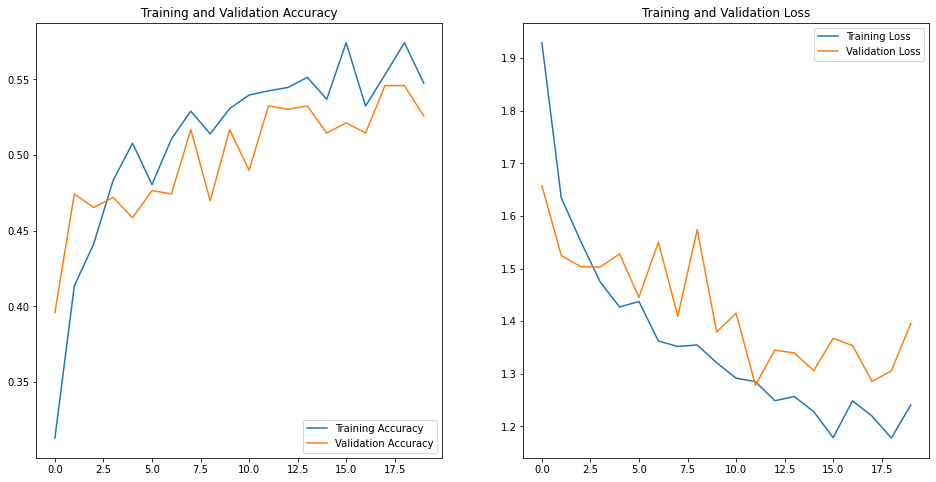

In [25]:
# Let's see the training and validation accuracy and loss after model is trained for 20 epochs

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**:
1. With the introduction of data augmentation strategy and dropout technique, the problem of model overfitting has been controlled but at the same time model's accuracy has been compromised. Training accuracy is ~55% and validation accuracy is ~53%.
2. However we can train the model for more epochs but there might be a chance that validation accuracy comes down with training accuracy increases. 

##### Let's make some improvement in the model by handling class imbalance which may cause the model inconsistent with training and validation data set

#### Find the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
# Find the path of all the training images and corresponding label class

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [27]:
# Check the distribution of classes in original dataset

dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

**Findings**: 
1. Class 'seborrheic keratosis' has the least number of samples, 77 images are available which are ~3.4% of total dataset.
2. Below 4 classes dominate the data in terms of proportionate number of samples, which contribute to ~73% of total dataset.
   - basal cell carcinoma (376 Samples)
   - melanoma (438 Samples)
   - nevus (357 Samples)
   - pigmented benign keratosis (462 Samples)

#### Rectify the class imbalance
**Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
# Installing the augmentor library

!pip install Augmentor

**To use `Augmentor`, the following general procedure is followed:**

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [32]:
## Adding 500 samples per class to make sure that none of the classes are sparse.

path_to_training_dataset=r'/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AF4028A50>: 100%|██████████| 500/500 [00:19<00:00, 25.04 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AEE3151D0>: 100%|██████████| 500/500 [00:19<00:00, 25.86 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0AF4028290>:   0%|          | 1/500 [00:00<00:57,  8.69 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AEE3ACA10>: 100%|██████████| 500/500 [00:19<00:00, 25.67 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F0AEE38B2D0>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F0B5532F390>: 100%|██████████| 500/500 [01:12<00:00,  6.90 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0AF6D735D0>: 100%|██████████| 500/500 [00:19<00:00, 25.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0AF6C97AD0>: 100%|██████████| 500/500 [00:42<00:00, 11.89 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0AF6CC7310>:   0%|          | 1/500 [00:00<01:00,  8.31 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0B532B9D50>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0AF6D97F90>: 100%|██████████| 500/500 [00:20<00:00, 24.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
# Check the count of total sample images created using augmentor library

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
# Find the path of all the sample images created using augmentor

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_78449bb3-f08c-4fa0-a708-b288757528c8.jpg',
 '/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_a4875263-cd3b-4b6f-afda-cedd3af6fb99.jpg',
 '/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_c97156e4-14f4-4e3c-81f0-24711961827a.jpg',
 '/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010862.jpg_d7585609-3644-4

In [35]:
# Find the label of all the sample images created using augmentor

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [36]:
# Check the distribution of classes in original + sample augmentor dataset

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [37]:
# Setting some parameters below for loading

batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width, 3)

#### Create a training dataset

In [38]:
# Creating training data set out from original + augmented data - Using 80% of the images for training
# Also resizing the image to 180x180

data_dir_train_with_aug = pathlib.Path(r'/gdrive/MyDrive/Colab Notebooks/Skin Cancer Detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
                  data_dir_train_with_aug,
                  seed=123,
                  validation_split = 0.2,
                  subset = 'training',
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [39]:
# Creating validation data set out from original + augmented data - Using 20% of the images for training
# Also resizing the image to 180x180

val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train_with_aug,
                seed=123,
                validation_split=0.2,
                subset='validation',
                image_size=(img_height, img_width),
                batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create the model - M3
#### Create another model with original and augmented data sets which handles the class imbalance problem

In [60]:
# Building the model with augmentor samples and dropout technique

model3 = Sequential([
        Rescaling(1./255, input_shape=image_size),
        Conv2D(16, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(class_names), activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [61]:
# Compiling the model using adam optimizer and sparse categorical cross entropy

model3.compile(optimizer='adam',
             loss=SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [62]:
# View the summary of all layers

model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 45, 45, 32)       

### Train the model

In [63]:
# Training the model for 20 epochs

epochs = 20
history3 = model3.fit(
            train_ds_aug,
            validation_data=val_ds_aug,
            epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 33s 188ms/step - loss: 1.9875 - accuracy: 0.2372 - val_loss: 1.7274 - val_accuracy: 0.3705
Epoch 2/20
169/169 [==============================] - 32s 184ms/step - loss: 1.5605 - accuracy: 0.4017 - val_loss: 1.4974 - val_accuracy: 0.4595
Epoch 3/20
169/169 [==============================] - 33s 190ms/step - loss: 1.3978 - accuracy: 0.4698 - val_loss: 1.3991 - val_accuracy: 0.4684
Epoch 4/20
169/169 [==============================] - 32s 182ms/step - loss: 1.2744 - accuracy: 0.5165 - val_loss: 1.3083 - val_accuracy: 0.5605
Epoch 5/20
169/169 [==============================] - 33s 192ms/step - loss: 1.1684 - accuracy: 0.5618 - val_loss: 1.2367 - val_accuracy: 0.5375
Epoch 6/20
169/169 [==============================] - 32s 186ms/step - loss: 1.0522 - accuracy: 0.6174 - val_loss: 1.1311 - val_accuracy: 0.5902
Epoch 7/20
169/169 [==============================] - 32s 185ms/step - loss: 0.9459 - accuracy: 0.6524 - val_loss: 1.0766 - val_accuracy: 0.6

### Visualizing the results

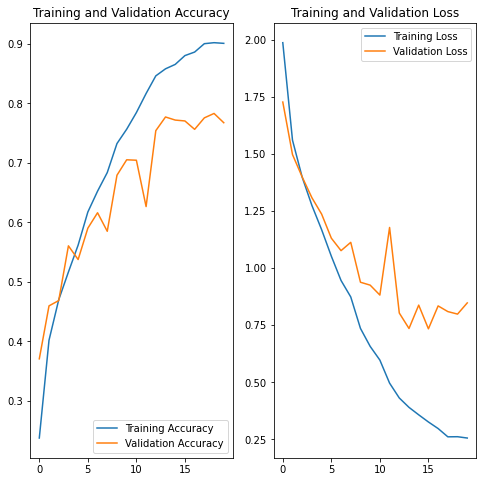

In [64]:
# Let's see the training and validation accuracy and loss after model is trained for 20 epochs

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**
1. We can see from the above plots that model's performance have been increased compared to M2 when class imbalance were handled with more number of samples generated using augmentor library.
2. However we can control the model overfitting by controlling the number of epochs and other hyperparameter tuning. But overall this model is giving good performance.